In [1]:
import torch
from torch import nn
from lib.mnist_aug import caption_rules
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug
from datetime import datetime

In [2]:
aug = MNISTAug()
aug.min_objects = 1
aug.max_objects = 1

In [3]:
dm = DataManager()
dm.load()

In [4]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 10000, get_positional_labels=True)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 10, get_positional_labels=True)

/home/ak/Repos/ml_gallery/ml_py/venv/lib/python3.8/site-packages/skimage/transform/_warps.py:115: RuntimeWarning: divide by zero encountered in true_divide
  factors = (np.asarray(input_shape, dtype=float) /


cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer
cannot convert float infinity to integer


In [5]:
x_train = torch.FloatTensor(x_train.reshape((-1, 1, 112, 112)))
x_test = torch.FloatTensor(x_test.reshape((-1, 1, 112, 112)))
x_train.shape

torch.Size([10000, 1, 112, 112])

center


/home/ak/Repos/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:444: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


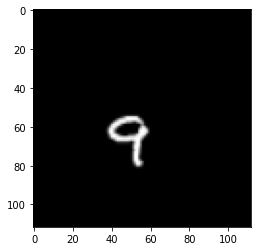

In [6]:
DataManager.plot_num(x_train[2].reshape((112, 112,)))
print(caption_rules.index_to_pos[y_train[2][0]['position']])

In [7]:
class PositionalEncoder2D(nn.Module):
    def __init__(self, c: int, h: int, w: int):
        super().__init__()
        self.w = (torch.rand((1, c, h, w)) - 0.5).requires_grad_()

    def forward(self, x):
        batch_size = x.shape[0]
        encoded = self.w.expand((batch_size, -1, -1, -1))
        return torch.cat((x, encoded), 1)

In [11]:
class PositionalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.pos_enc = PositionalEncoder2D(10, 5, 5)
        self.positional_compression = nn.Sequential(
            nn.Conv2d(32 + 10, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(nn.Linear(32, 10), nn.Softmax())
        self.position_classifier = nn.Sequential(nn.Linear(32, 9), nn.Softmax())

    def forward(self, x):
        features = self.features(x)
        positional_features = self.pos_enc(features)
        compressed = self.positional_compression(positional_features)
        flattened = torch.flatten(compressed, 1)
        cls = self.classifier(flattened)
        pos = self.position_classifier(flattened)
        return cls, pos

In [15]:
model = PositionalClassifier()
optimizer = torch.optim.Adam(model.parameters())
position_loss = torch.nn.CrossEntropyLoss()

In [16]:
epochs = 55
batch_size = 100

for epoch in range(epochs):

    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size

        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        y_pos = torch.tensor([y[0]['position'] for y in y_batch])
        y_cls = torch.tensor([y[0]['class'] for y in y_batch])

        optimizer.zero_grad()

        cls, pos = model(x_batch)

        loss_pos = position_loss(pos, y_pos)
        loss_cls = position_loss(cls, y_cls)

        loss = 1 * loss_cls + 0.1 * loss_pos

        loss.backward()
        optimizer.step()

        losses += float(loss)

    print(f'{epoch=}, loss={float(losses)}')

epoch=0, loss=250.40300726890564
epoch=1, loss=240.920423746109
epoch=2, loss=235.54661083221436
epoch=3, loss=231.39110898971558
epoch=4, loss=228.6484889984131
epoch=5, loss=226.77877831459045


KeyboardInterrupt: 

center bottom
6 0
---
center left
6 1
---
center left
6 1
---
center top-right
6 3
---
center top-right
6 2
---
center center
6 4
---
center top
6 1
---
center top
6 7
---
center center
6 5
---
center center
6 7
---


/home/ak/Repos/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:444: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


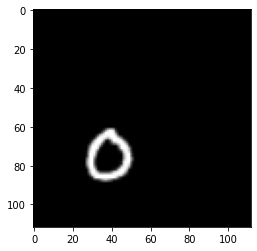

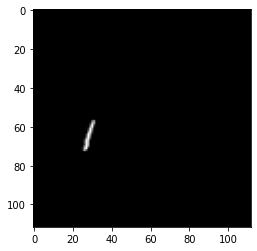

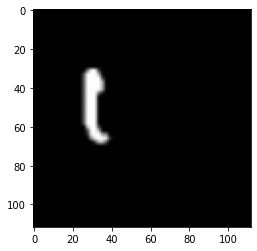

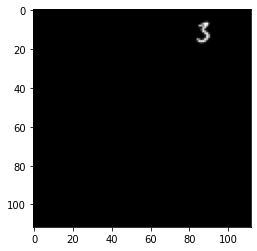

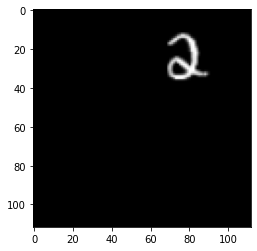

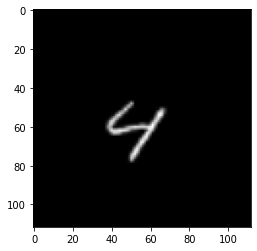

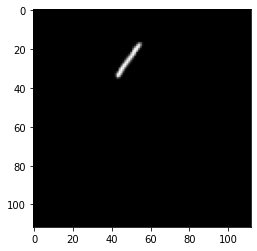

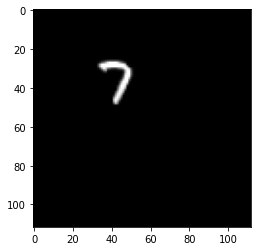

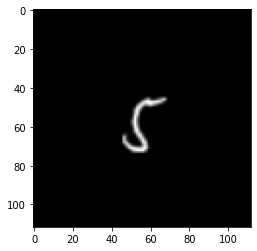

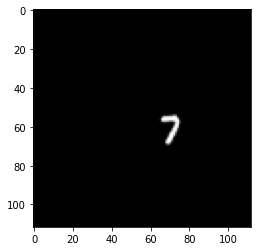

In [14]:
cls, pos = model(x_test)
_, pos = pos.max(1)
_, cls = cls.max(1)

y_test_pos = [y[0]['position'] for y in y_test]
y_test_cls = [y[0]['class'] for y in y_test]

for i in range(len(pos)):
    print(caption_rules.index_to_pos[int(pos[i])], caption_rules.index_to_pos[y_test_pos[i]])
    print(int(cls[i]), y_test_cls[i])
    print('---')
    DataManager.plot_num(x_test[i].reshape(112, 112))

In [ ]:
pos_enc = model.pos_enc.w

c1 = pos_enc[0][0].detach().numpy()

DataManager.plot_num(c1)


In [ ]:
def save_model(model, message=None):
    last_saved_model_path = f'./models/model_{int(datetime.now().timestamp())}{f"_{message}" if message else ""}.pt'
    torch.save(model.state_dict(), last_saved_model_path)
#save_model(model, message='test')
